# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file
style.use('default')

In [2]:
plt.rcParams['backend'] = 'SVG'

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [3]:
df = pd.read_excel('../data/HIST_PAINEL_COVIDBR_25jul2020.xlsx')
# tratamento inicial dos valores de população
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'DF'
Muni = 'Brasília'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_filter_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = preproc_filter_df(df, uf, Muni)

In [8]:

def casos_acumulados(df_muni, muni, pathfigs = './figs/'):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_log10_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Novos\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    print('Casos Totais\n', df_muni['casosAcumulado'].max())
    

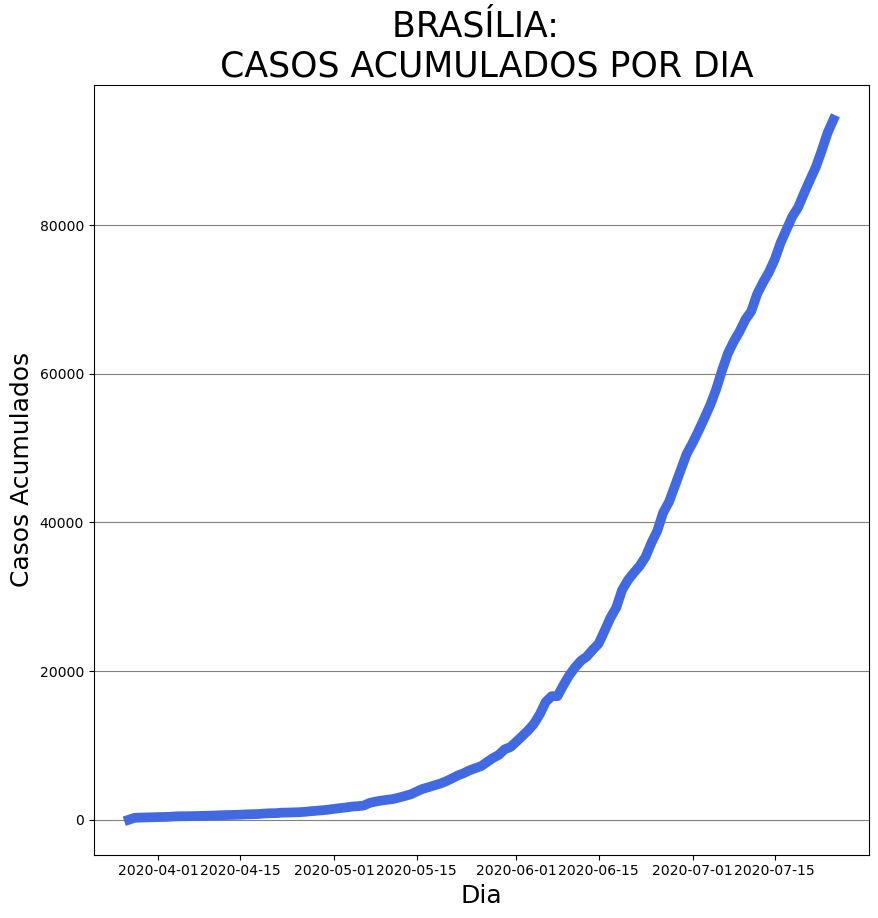

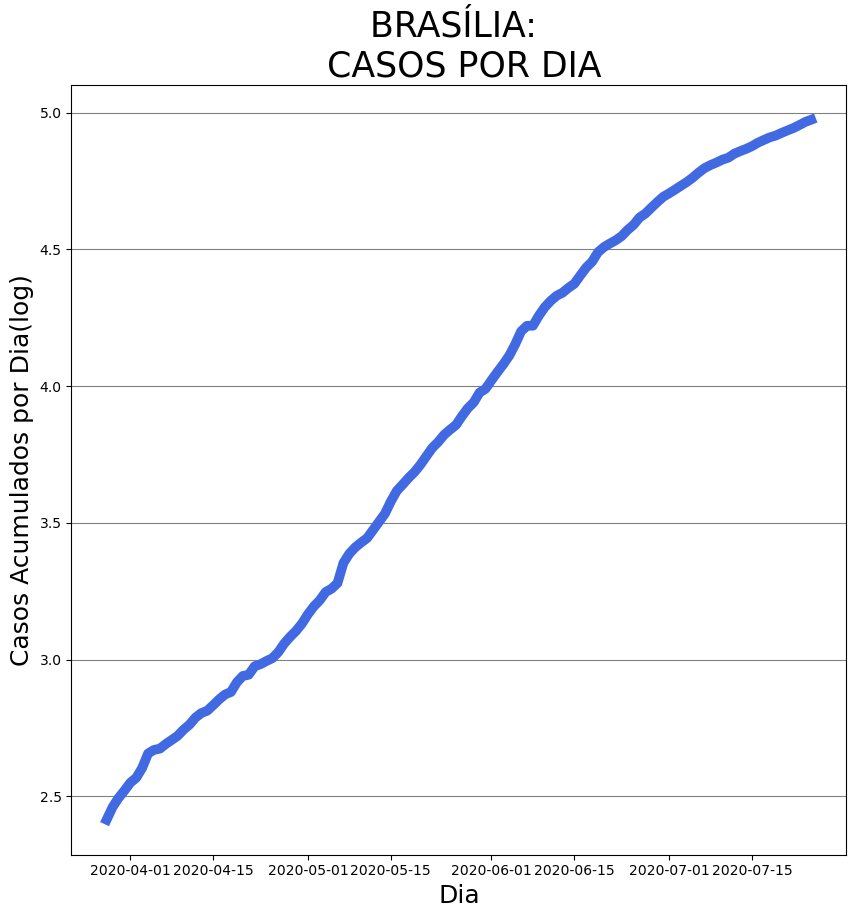

dia zero 2020-03-27 00:00:00
Casos Novos
         casosNovos       data
672525        2306 2020-07-12
672526        1572 2020-07-13
672527        1370 2020-07-14
672528        1725 2020-07-15
672529        2242 2020-07-16
672530        1779 2020-07-17
672531        1763 2020-07-18
672532        1249 2020-07-19
672533        1875 2020-07-20
672534        1789 2020-07-21
672535        1725 2020-07-22
672536        2222 2020-07-23
672537        2391 2020-07-24
672538        1773 2020-07-25
Casos Totais
 94187


In [9]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [10]:
def casos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    print('Casos Totais\n', df1['casosAcumulado'].max())

    fig = plt.figure(1, figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='casosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    
    plt.title('{}: \n Casos por Semana Epidemiológica por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=20)
    plt.ylabel('Número de Casos', fontsize=20)
    plt.grid(axis='y', color='grey')
    plt.rcParams['legend.title_fontsize'] = 18

    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)

Casos Totais
 94187


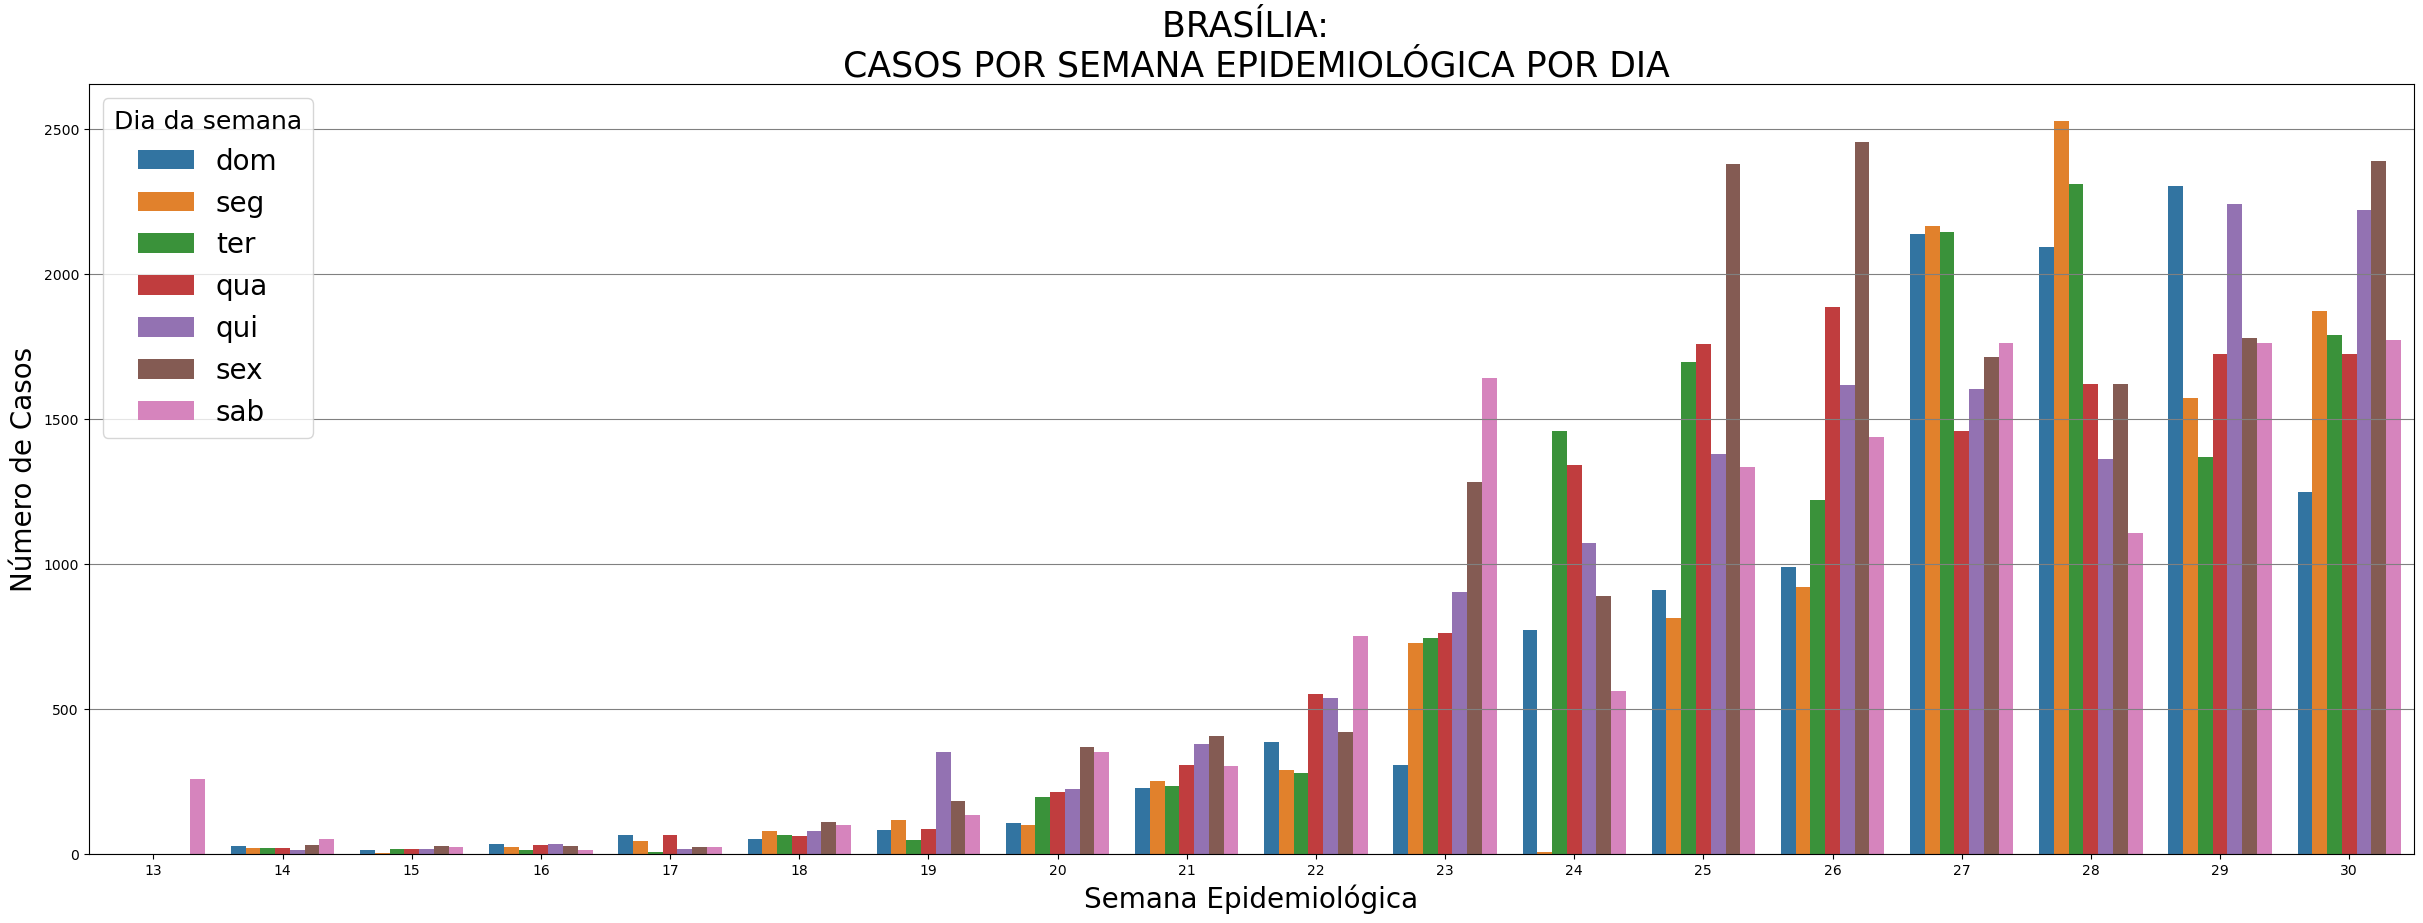

In [11]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 5 dias centralizada)

In [12]:
def casos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(5, center=True)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( pathfigs + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

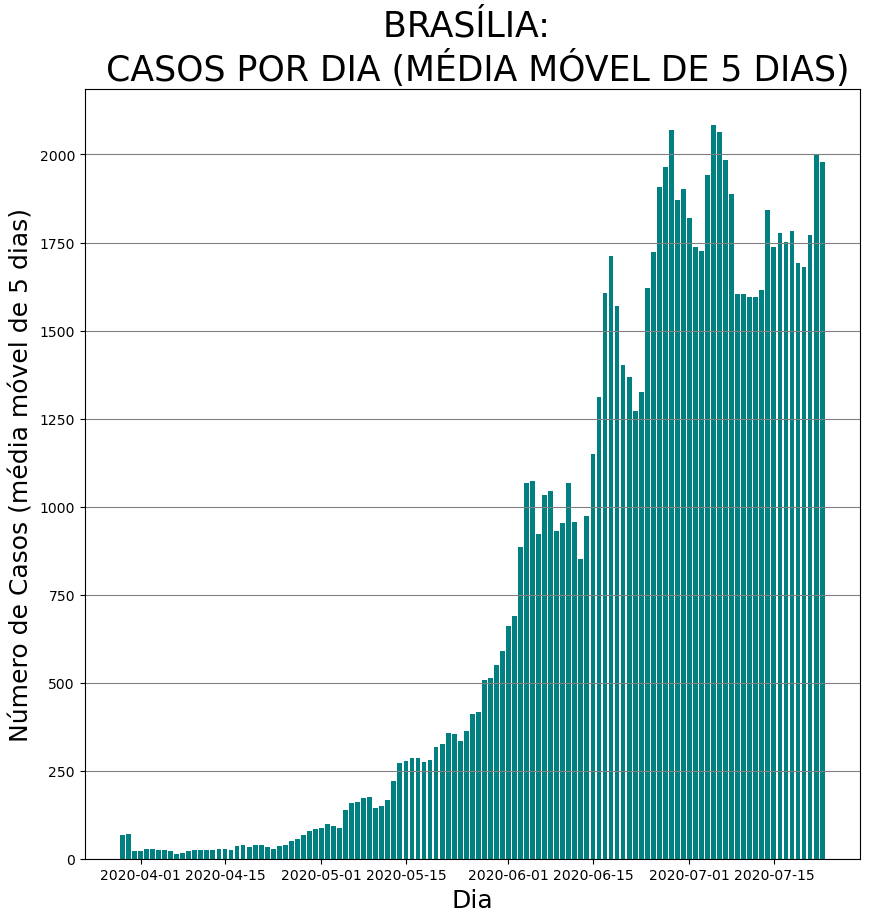

Média móvel por dia
         media_movel_casos       data
672418                NaN 2020-03-27
672419                NaN 2020-03-28
672420               66.4 2020-03-29
672421               71.0 2020-03-30
672422               22.0 2020-03-31
672423               22.6 2020-04-01
672424               28.4 2020-04-02
672425               27.2 2020-04-03
672426               23.6 2020-04-04
672427               24.4 2020-04-05
672428               21.4 2020-04-06
672429               14.6 2020-04-07
672430               17.4 2020-04-08
672431               21.2 2020-04-09
        media_movel_casos       data
672525             1595.4 2020-07-12
672526             1616.4 2020-07-13
672527             1843.0 2020-07-14
672528             1737.6 2020-07-15
672529             1775.8 2020-07-16
672530             1751.6 2020-07-17
672531             1781.6 2020-07-18
672532             1691.0 2020-07-19
672533             1680.2 2020-07-20
672534             1772.0 2020-07-21
672535           

In [13]:
casos_dia_media_movel(df_cidade, Muni)

In [14]:
def obitos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))
    print('Óbitos Totais\n', df1['obitosAcumulado'].max())

    fig =  plt.figure(1,figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='obitosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    plt.title('{}: \n Óbitos por Semana Epidemiológica por dia da semana'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
    


Óbitos por dia
         obitosNovos       data
672525           31 2020-07-12
672526           28 2020-07-13
672527           30 2020-07-14
672528           41 2020-07-15
672529           36 2020-07-16
672530           23 2020-07-17
672531           15 2020-07-18
672532           10 2020-07-19
672533           27 2020-07-20
672534           46 2020-07-21
672535           18 2020-07-22
672536           42 2020-07-23
672537           26 2020-07-24
672538           31 2020-07-25
Óbitos Totais
 1275


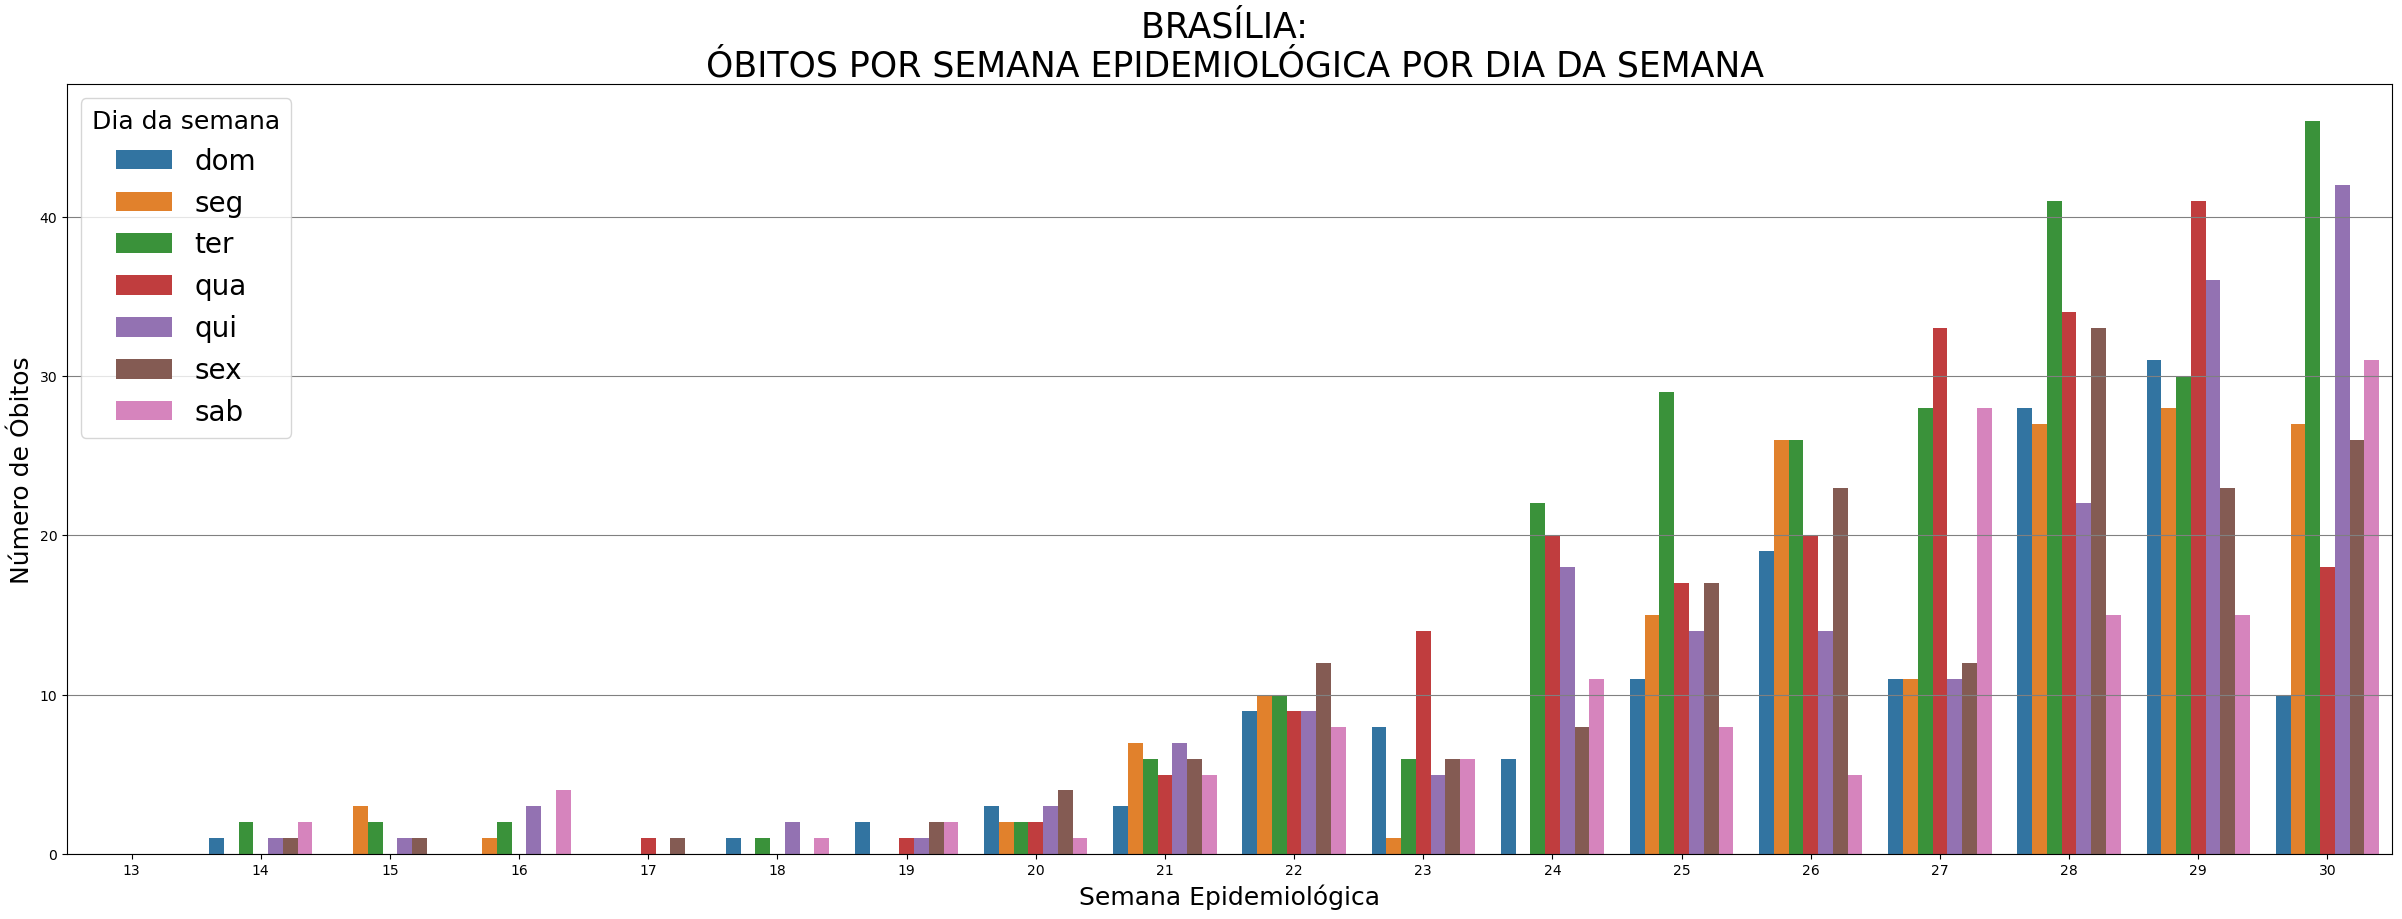

In [15]:
obitos_dia_local(df_cidade, Muni)

### Obitos por dia (média movel de 5 dias centralizada)

In [16]:
def obitos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(5, center=True)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( pathfigs + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

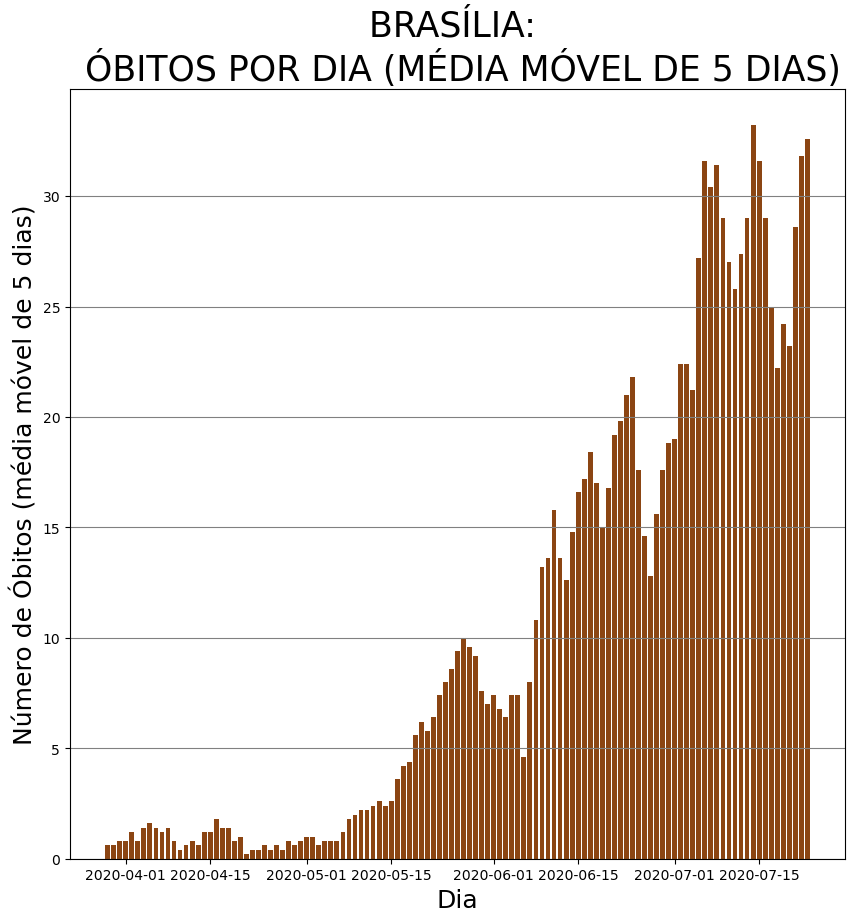

Média móvel por dia
         media_movel_obitos       data
672418                 NaN 2020-03-27
672419                 NaN 2020-03-28
672420                 0.6 2020-03-29
672421                 0.6 2020-03-30
672422                 0.8 2020-03-31
672423                 0.8 2020-04-01
672424                 1.2 2020-04-02
672425                 0.8 2020-04-03
672426                 1.4 2020-04-04
672427                 1.6 2020-04-05
672428                 1.4 2020-04-06
672429                 1.2 2020-04-07
672430                 1.4 2020-04-08
672431                 0.8 2020-04-09
        media_movel_obitos       data
672525                27.4 2020-07-12
672526                29.0 2020-07-13
672527                33.2 2020-07-14
672528                31.6 2020-07-15
672529                29.0 2020-07-16
672530                25.0 2020-07-17
672531                22.2 2020-07-18
672532                24.2 2020-07-19
672533                23.2 2020-07-20
672534                28.6 20

In [17]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [18]:
def casos_semana_local(df, local, pathfigs = './figs/'):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( pathfigs + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

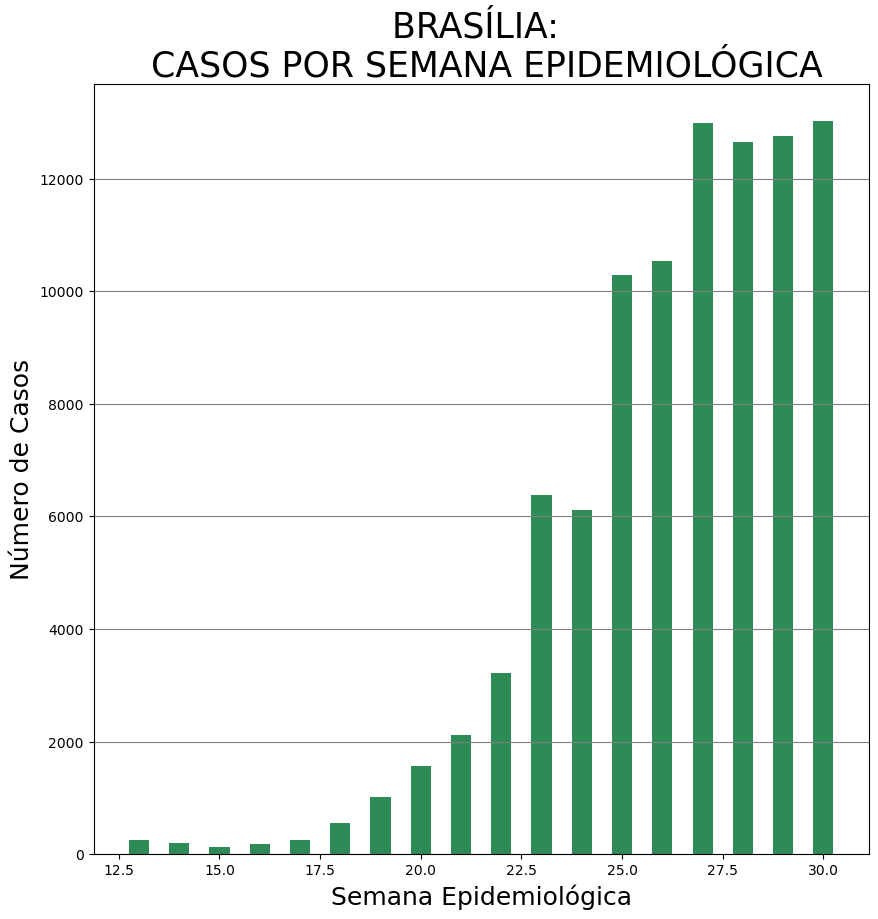

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13         260
1          14         194
2          15         125
3          16         183
4          17         251
5          18         553
6          19        1010
7          20        1564
8          21        2111
9          22        3223
10         23        6376
11         24        6109
12         25       10279
13         26       10528
14         27       12994
15         28       12646
16         29       12757
17         30       13024


In [19]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [20]:
def obitos_semana_local(df, local, pathfigs = './figs/'):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( pathfigs + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')


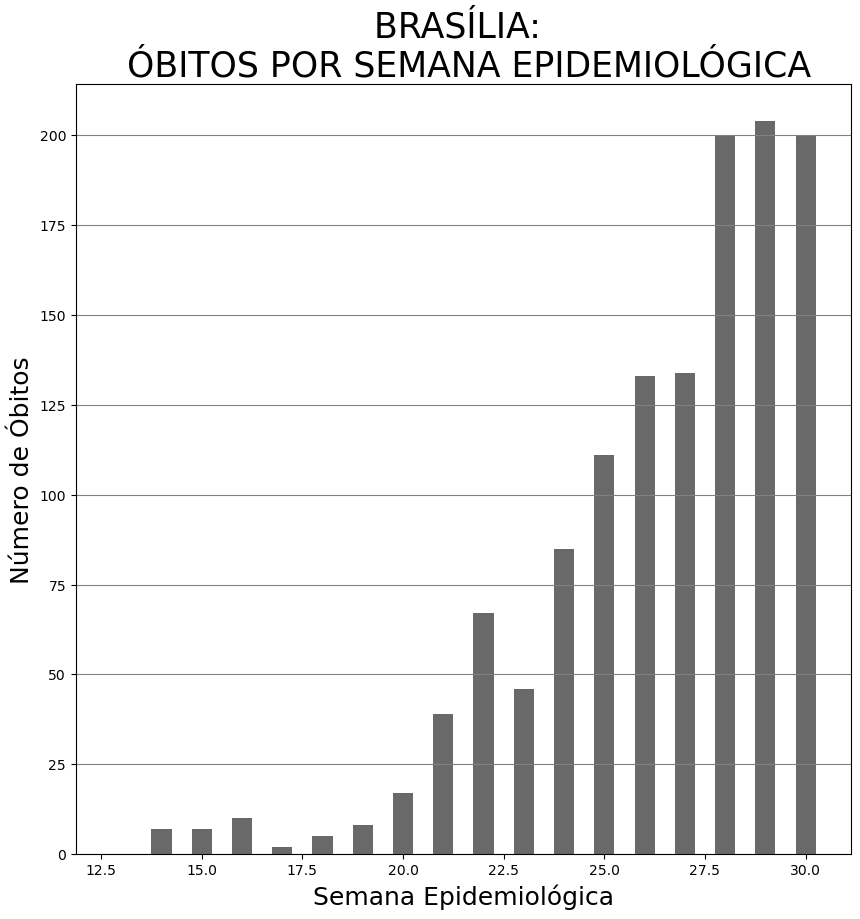

In [21]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [22]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid\acompanhamento_df


'd:\\GitRepos\\graficos_covid\\acompanhamento_df\\geojsonDL\\DF.json'

### Carregando arquivo GeoJson do estado

In [23]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [24]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid-19 -- {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

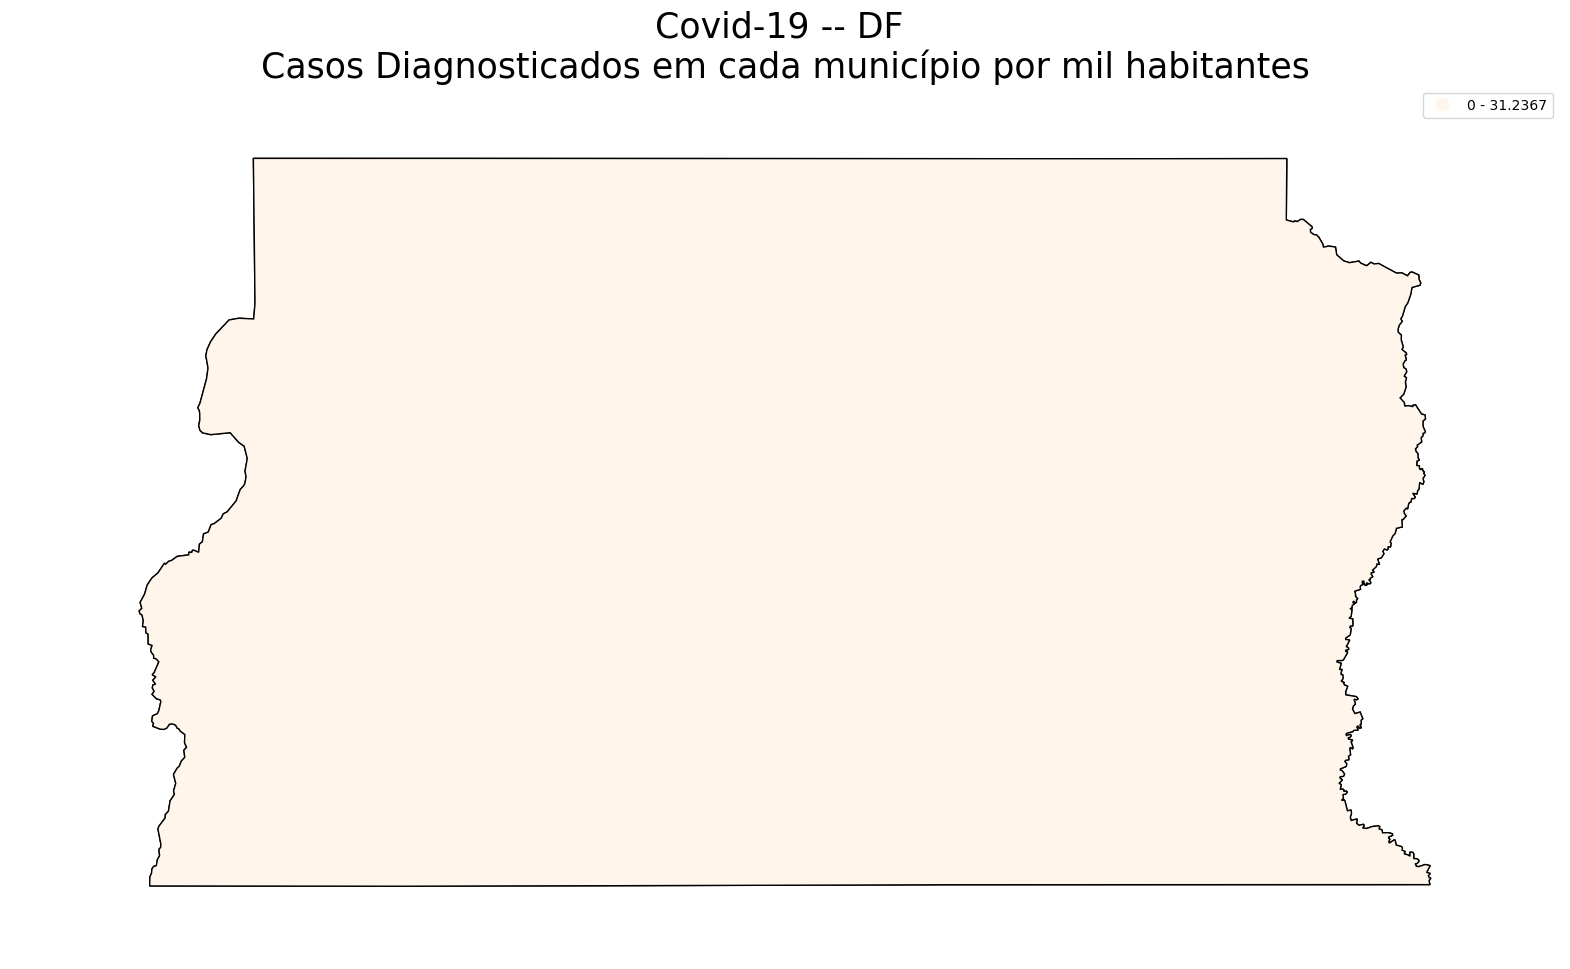

In [25]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

In [26]:
def mapa_obitos_estado(df, df_geo, uf, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid-19 -- {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


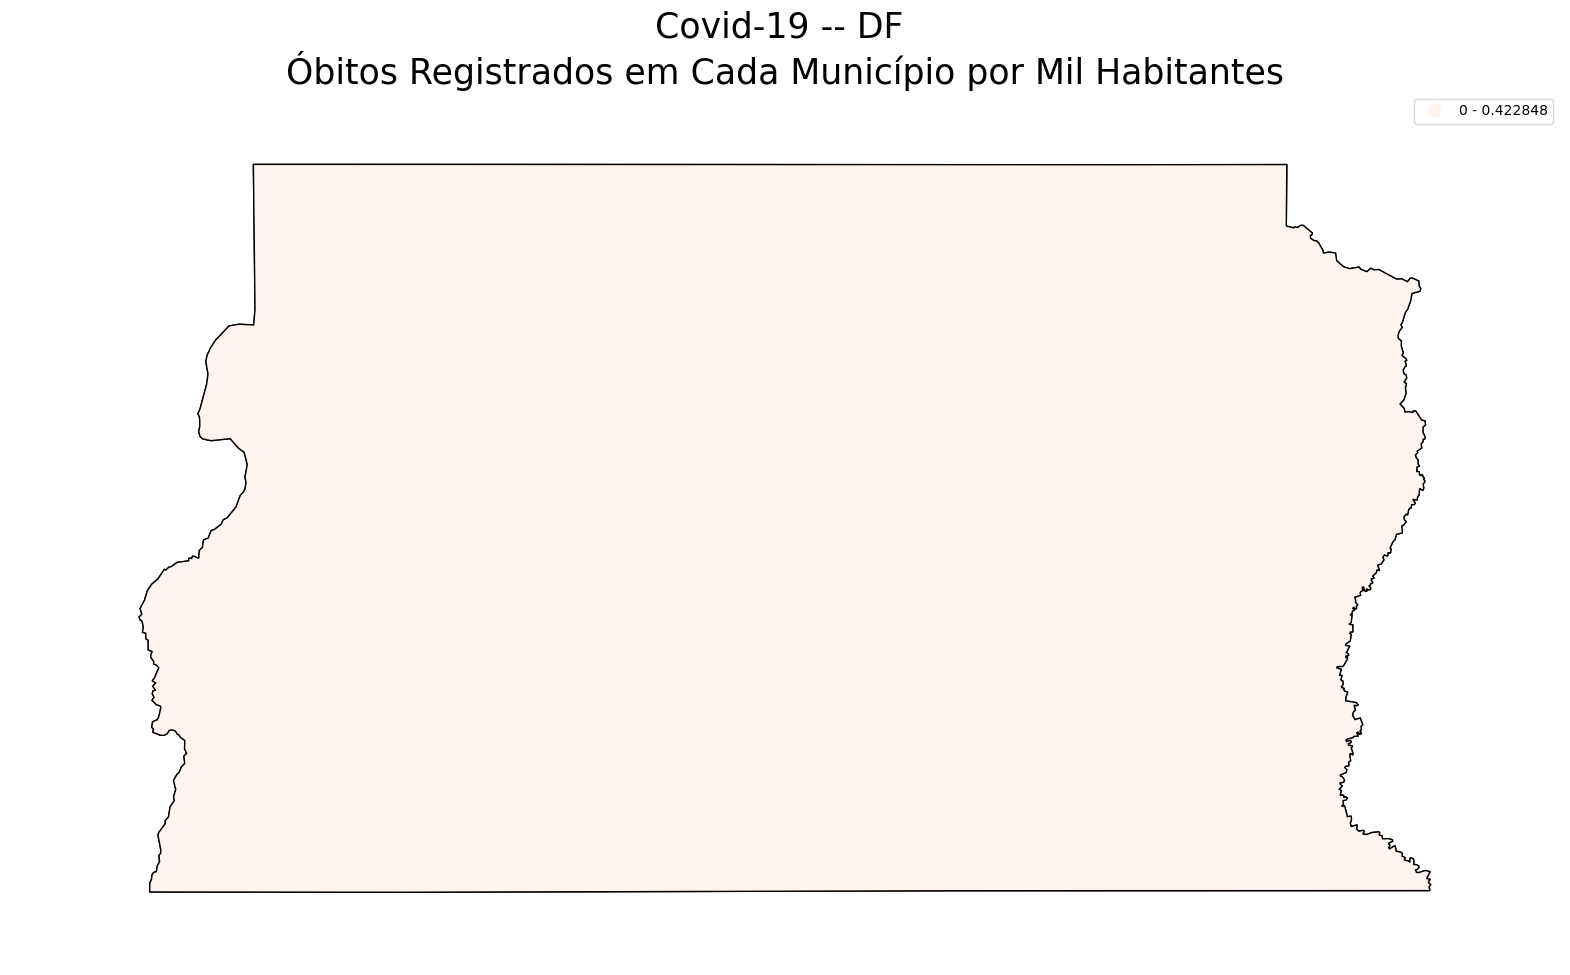

In [27]:
mapa_obitos_estado(df_est, mapa, uf, 20)